In [1]:
%matplotlib inline


# 2.1 数据载入和处理
**作者**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

机器学习中的大部分工作主要是在准备数据。PyTorch提过了许多工具使得数据载入更加简单和方便，而且可以使得代码可读性更好。在本教程中，我们将会看到如何从不平凡的数据中进行数据载入，数据准备和数据扩展。

为了运行本教程，需要保证安装如下软件包：

-  ``scikit-image``: 用于图像输入输出和转换
-  ``pandas``: 用于简单的csv格式转换

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 忽视警告
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # 交互模型
plt.show()

我们处理的数据集是人脸姿态。人脸被注释为如下：

.. figure:: /_static/img/landmarked_face2.png
   :width: 400

所有的，在每张人脸上会标注上68个不同标记节点。

<div class="alert alert-info"><h4>记录</h4><p>在这里下载数据集 <https://download.pytorch.org/tutorial/faces.zip>`_
    因此图像放在文件夹'data/faces/'中。
    该数据集是应用优秀的dlib姿态估计器生成的
    <https://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`__
    一部分来自Imagenet数据集的图片被打上了'face'的标签。</p></div>

从csv格式文件注释的数据集会变为如下：
::

    image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
    0805personali01.jpg,27,83,27,98, ... 84,134
    1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

让我们阅读CSV并且在一个(N, 2)阵列中得到注释，这里的N表示表示标记的数量。上面显示N=68


In [3]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 32.  65.]
 [ 33.  76.]
 [ 34.  86.]
 [ 34.  97.]]


写一个简答的帮助函数来显示图像和标记，并且使用它显示一个样本。

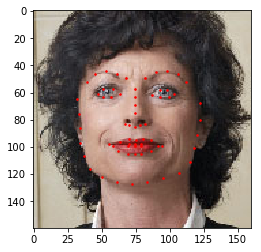

In [4]:
def show_landmarks(image, landmarks):
    """和标记一起显示图像"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # 暂停一个比特用于更新画图

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

### 数据类别

``torch.utils.data.Dataset``是一个表示数据集的抽象类。
自定义的数据集需要集成``Dataset``并且重载一下方法：

-  ``__len__``。使用``len(dataset)``返回数据集的尺寸。
-  ``__getitem__``支持索引数据，``dataset[i]``可以得到第$i$个样本数据

创建一个类用于表示我们的人脸标记数据集。在``__init__``中读取csv文件，在``__getitem__``中读取图像数据。这样做的目的是提高效率，因为并不是将所有图片放在内存中，而是在需要使用的时候才读取到内存中。

数据集的样本是个字典，形式如：``{'image':image, 'landmarks':landmarks}``。我们的数据集需要提供一个可选的参数``transform``，用来对样本进行处理提供借口。在下节中可以看到``transform``的用处。

In [5]:
class FaceLandmarksDataset(Dataset):
    '''人脸标记数据集'''

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): csv文件路径。
            root_dir (string): 所有文件的文件夹。
            transform (callable, optional): 可选的转换操作，可用于样本的处理。
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

首先实例化该类，并且迭代读取数据样本。我打印出最开始的4个样本，并显示其对应的人脸姿态。

0 (324, 215, 3) (68, 2)
1 (500, 333, 3) (68, 2)
2 (250, 258, 3) (68, 2)
3 (434, 290, 3) (68, 2)


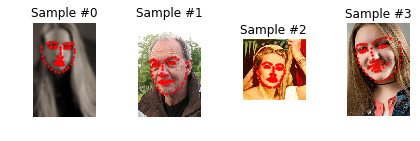

In [6]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

### 转换

上述图像的一个问题是每个样本的尺寸不相同。大多数神经网络期望输入具有相同的尺寸。因此，我们需要编写预处理代码。

主要一下三个变换函数：

-  ``Rescale``: 重新更改图像的尺寸
-  ``RandomCrop``: 随机裁剪图像。这是数据扩展的方式之一。
-  ``ToTensor``: 将numpy图像转换为torch图像(我们需要交换部分坐标)。

我们将上述三个变换函数写成回调类，而不是普通的函数，所以转换函数的参数不需要每次调用的时候都传进去。为了达成这个目标，我们需要实现``__call__``方法，并且如果需要的话，也要实现``__init__``方法。我们可以是用transform如下所示：

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)

下面将观察到这些变换将如何被应用到图像和图像标记中。

In [7]:
class Rescale(object):
    """将样本图像转换为给定尺寸。

    参数:
        output_size (tuple或者int): 给定输出尺寸。 
        如果输出尺寸是元组，输出将会匹配输出尺寸。
        如果输出尺寸是整形，更小的图像边缘将会以相同的比率匹配到输出尺寸上。
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # 因为对于图像标记而言，h和w需要交换。
        # x和y分别对应坐标1和0
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
    """在样本中随机裁剪图像。

    参数:
        output_size (tuple or int): 期望的输出尺寸。如果是整形，则裁剪为方形。
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """将样本中numpy类型ndarray转化为torch的tensor。"""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # 交换颜色坐标，因为
        # numpy图像：H x W x C
        # torch图像：C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

#### 组合转换函数 

现在将上述转换操作应用到样本中。

首先将图像的短边转换为256，然后随机裁剪图像的尺寸为224.例如，我们想组合``Rescale``和``RandomCrop``操作。``torchvision.transform.Compose``是一个可以用于此类操作的简单回调类。

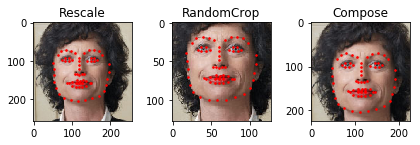

In [8]:
scale = Rescale(256)
crop = RandomCrop(128)
# 有点像做pipeline。
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# 对每个样本使用上述变换。
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

#### 数据集的迭代操作

综上，我们使用组合转换来创建一个数据集。

总结上述操作，数据集的创建需要以下工作：

-  在线从文件中读取图像
-  在读取的图像中使用变换
-  因为这些变换中的一个是随机的，因此通过采用可以扩展数据集。

可以使用``for i in range``循环来迭代创建数据集。

In [9]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


但是，我们使用``for``循环进行迭代读取数据的过程中会丢失大量的特征。特别我们可以错过一些重要信息，如：

-  批量化数据
-  随机打乱数据
-  使用多处理器并行载入数据

``torch.utils.data.DataLoader``是一个提供了上述所有特点的迭代器。下面使用的参数需要清空。一个有意思的参数是``collate_fn``。使用``collate_fn``可以制定如何批量的获取样本。但是对于大多数用例需要默认的核对正常。

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


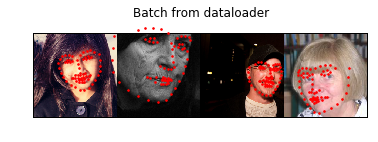

In [10]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

# 用于显示批量的帮助函数
def show_landmarks_batch(sample_batched):
    """显示一批样本的图像和人脸姿态标记"""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # 观察一批4个，然后停止
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

#### 后记：torchvison

在本教程中，我们已经看到了如何编写和使用数据集，以及数据转换和数据载入。``torchvision``软件包提供一些有用的数据集和转换器。你不需要自己取写定制的类。最通用的数据集torchvision之一是``ImageFolder``。它假设图像是按照如下格式分布的：

    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png

这里'ants'，’bees'是类别标记。相似的在``PIL.Image``上进行操作的通用变换，如``RandomHorizontalFlip``和``Scale``是类似的。你可以写一个数据载入器如下所示：

``` python
  import torch
  from torchvision import transforms, datasets

  data_transform = transforms.Compose([
          transforms.RandomSizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
      ])
  hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                             transform=data_transform)
  dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                               batch_size=4, shuffle=True,
                                               num_workers=4)
```
For an example with training code, please see
:doc:`transfer_learning_tutorial`.

